# Calculating catches from gridded DBPM outputs
**Author**: Denisse Fierro Arcos  
**Date**: 2025-02-06  

In this notebook, we will calculate catches from gridded DBPM outputs.

## Loading relevant libraries

In [1]:
import os
from glob import glob
import xarray as xr
import json
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client

## Start a cluster for parallelisation

In [2]:
client = Client(threads_per_worker = 1)

## Defining basic variables to run gridded DBPM

In [3]:
#Name of region and model resolution
region = 'fao-58'
model_res = '1deg'

#Defining input and output folders
base_folder = '/g/data/vf71/la6889/dbpm_inputs/east_antarctica/'
gridded_inputs = os.path.join(base_folder, 'gridded_params', model_res)
gridded_outputs = os.path.join(base_folder, 'run_fishing', model_res)

## Loading gridded parameters and gridded inputs

In [4]:
#Loading gridded parameters
gridded_params = json.load(open(
    os.path.join(base_folder, 'gridded_params', model_res,
                 f'dbpm_gridded_size_params_{region}_python.json')))

#Loading mortality from fishing
fish_mort_det = xr.open_zarr(glob(
    os.path.join(gridded_inputs, 'fish-mort-det*'))[0])['fish_mort_det']
fish_mort_pred = xr.open_zarr(glob(
    os.path.join(gridded_inputs, 'fish-mort-pred*'))[0])['fish_mort_pred']

#Loadding effort - Only initial time step
effort_init = xr.open_zarr(glob(
    os.path.join(gridded_inputs, 'effort_spinup*'))[0])['effort'].isel(time = 0)

#Size class bins
log10_size_bins_mat = xr.open_zarr('outputs/log10_size_bins_matrix.zarr/')['size_bins']
size_bin_vals = 10**log10_size_bins_mat

## Loading gridded DBPM outputs 

In [5]:
predators = xr.open_mfdataset(glob(
    os.path.join(gridded_outputs, 'predators*')))['predators']

detritivores = xr.open_mfdataset(glob(
    os.path.join(gridded_outputs, 'detritivores*')))['detritivores']

effort = xr.open_mfdataset(glob(os.path.join(gridded_outputs, 'effort*')))['effort']

#Add initial effort values
effort = xr.concat([effort_init, effort], dim = 'time')

## Calculate fishing mortality 

In [6]:
fishing_mort_pred = fish_mort_pred*effort
fishing_mort_det = fish_mort_det*effort

## Calculates catches per time step and size class
`fishing_mort_pred` and `fishing_mort_det` are set to zero outside the sizes for each class, so there is no need to apply a mask here.

In [7]:
catch_pred = fishing_mort_pred*predators*size_bin_vals
catch_det = fishing_mort_det*detritivores*size_bin_vals

## Calculate biomass for catches 

In [8]:
tot_catch_pred = ((catch_pred*gridded_params['log_size_increase']).
                  sum(('size_class', 'lat', 'lon')))

tot_catch_det = ((catch_det*gridded_params['log_size_increase']).
                  sum(('size_class', 'lat', 'lon')))

total_catch = tot_catch_det+tot_catch_pred

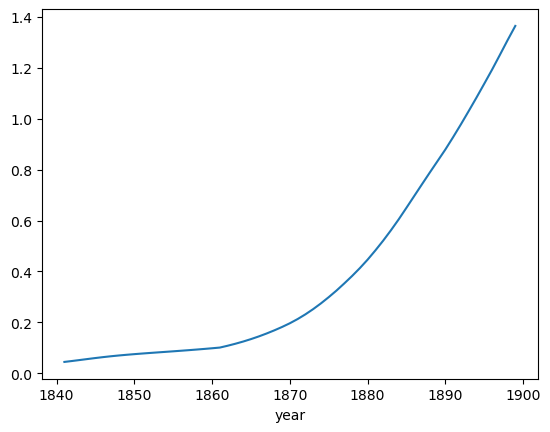

In [9]:
total_catch.groupby('time.year').mean('time').plot()

## Calculate total biomass for `predators` and `detritivores` 

In [90]:
tot_pred_bio = ((predators.isel(size_class = slice(gridded_params['ind_min_pred_size'], 
                                                  None))*
                gridded_params['log_size_increase']*size_bin_vals).
                sum(('size_class', 'lat', 'lon')))

tot_pred_det = (detritivores.isel(size_class = 
                                  slice(gridded_params['ind_min_detritivore_size'], 
                                        None))*gridded_params['log_size_increase']*
                size_bin_vals).sum(('size_class', 'lat', 'lon'))